## Installing medmnist, torcheval, pytorch-ignite and matplotlib

In [ ]:
!pip install medmnist torcheval pytorch-ignite matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import ConcatDataset

import torchvision.transforms as transforms

from tqdm import tqdm

from ignite.metrics import Recall, Precision, RocCurve, PrecisionRecallCurve, ConfusionMatrix
from torcheval.metrics import MulticlassAUPRC, functional as F1

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

import medmnist
from medmnist import INFO, Evaluator

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


In [ ]:
# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 30
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
validate_dataset = DataClass(split='val', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
validation_loader = data.DataLoader(dataset=validate_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 559580/559580 [00:00<00:00, 6719618.85it/s]

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


In [ ]:
print(train_dataset)
print("===================")
print(validate_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 78
    Root location: /root/.medmnist
    Split: val
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'

/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:32: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


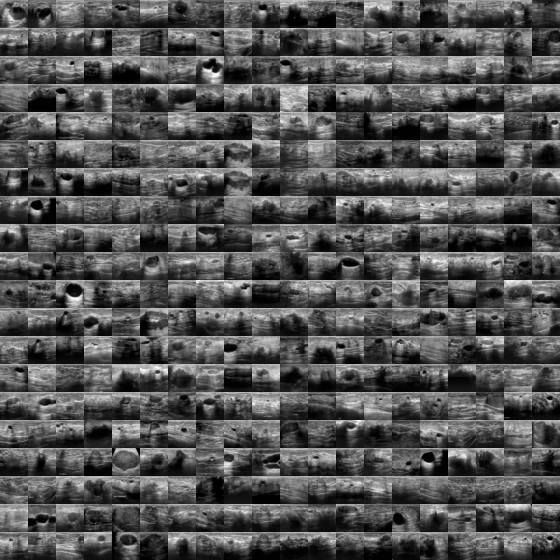

In [ ]:
# montage
train_dataset.montage(length=20)

## 1. Proposed Modified ResNet18 Model

In [ ]:
class ModifiedResNet18(nn.Module):
    """
    Modified ResNet-18 model for MedMNIST classification tasks.

    It contains the following methods:
    - __init__: Initializes the model.
    - forward: Defines the forward pass.
    """

    def __init__(self, num_classes, in_channels, dropout):
        """
        A method to initialize the ModifiedResNet18 model.

        :param num_classes: The number of classes in the dataset.
        :param in_channels: The number of input channels.
        :param dropout: The dropout rate.
        """

        super(ModifiedResNet18, self).__init__()

        # Load the pretrained ResNet-18 model
        self.resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

        # Modify the first layer to accept grayscale images, and change the stride, padding, kernel size, and bias
        self.resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=True)

        # Get the number of features in the last layer
        num_ftrs = self.resnet.fc.in_features

        # Modify the last layer to output the number of classes in the dataset
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=dropout), # Apply dropout
            nn.Linear(num_ftrs, num_classes),
        )

        # Moving the model to the device
        self.resnet = self.resnet.to(device)

    def forward(self, x):
        """
        A method to define the forward pass.

        :param x: The input data.
        :return: The output data.
        """

        x = self.resnet(x)
        return x

# Create the model
model = ModifiedResNet18(num_classes=n_classes, in_channels=n_channels, dropout=0.8)
model.to(device)

# Create the loss function, optimizer, and learning rate scheduler
criterion = criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.7)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 54.9MB/s]


## 1. Training Modified ResNet18 Model

In [ ]:
# Training the model

# Setting the patience, best metric sum, and counter for early stopping
patience = 7
best_metric_sum = -float('inf')
counter = 0

# Training the model
for epoch in range(NUM_EPOCHS):
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        targets = targets.squeeze().long()
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()
    scheduler.step()

    # Early stopping using validation data
    model.eval()
    val_loss = 0
    val_batches = 0

    with torch.no_grad():
        y_true = torch.tensor([]).to(device)
        y_score = torch.tensor([]).to(device)

        for inputs, targets in validation_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            outputs = outputs.softmax(dim=-1)
            targets = targets.float().resize_(len(targets), 1)

            val_loss += loss.item()
            val_batches += 1

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        evaluator = Evaluator(data_flag, 'val')
        metrics = evaluator.evaluate(y_score.cpu().numpy())

        auc = metrics[0]
        accuracy = metrics[1]

        print('Epoch %d: Validation auc: %.3f, acc: %.3f' % (epoch + 1, auc, accuracy))

        val_loss /= val_batches

        # Creating a metric sum of AUC and accuracy
        metric_sum = (auc + accuracy) / 2

        # Save the model with the best metric sum
        if metric_sum > best_metric_sum:
            best_metric_sum = metric_sum
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1

        # Early stopping
        if counter >= patience:
            print("Early stopping: Stop training after {} epochs of no improvement in AUC and accuracy".format(patience))
            break

# Loading the best model
model.load_state_dict(torch.load('best_model.pth'))

100%|██████████| 18/18 [00:01<00:00, 13.65it/s]


Epoch 1: Validation auc: 0.490, acc: 0.731


100%|██████████| 18/18 [00:00<00:00, 42.01it/s]


Epoch 2: Validation auc: 0.693, acc: 0.654


100%|██████████| 18/18 [00:00<00:00, 40.01it/s]


Epoch 3: Validation auc: 0.801, acc: 0.744


100%|██████████| 18/18 [00:00<00:00, 37.98it/s]


Epoch 4: Validation auc: 0.843, acc: 0.744


100%|██████████| 18/18 [00:00<00:00, 31.63it/s]


Epoch 5: Validation auc: 0.870, acc: 0.859


100%|██████████| 18/18 [00:00<00:00, 49.80it/s]


Epoch 6: Validation auc: 0.904, acc: 0.846


100%|██████████| 18/18 [00:00<00:00, 47.47it/s]


Epoch 7: Validation auc: 0.854, acc: 0.821


100%|██████████| 18/18 [00:00<00:00, 56.00it/s]


Epoch 8: Validation auc: 0.844, acc: 0.897


100%|██████████| 18/18 [00:00<00:00, 53.39it/s]


Epoch 9: Validation auc: 0.830, acc: 0.821


100%|██████████| 18/18 [00:00<00:00, 51.60it/s]


Epoch 10: Validation auc: 0.830, acc: 0.859


100%|██████████| 18/18 [00:00<00:00, 54.17it/s]


Epoch 11: Validation auc: 0.860, acc: 0.872


100%|██████████| 18/18 [00:00<00:00, 53.25it/s]


Epoch 12: Validation auc: 0.929, acc: 0.897


100%|██████████| 18/18 [00:00<00:00, 53.86it/s]


Epoch 13: Validation auc: 0.940, acc: 0.910


100%|██████████| 18/18 [00:00<00:00, 49.35it/s]


Epoch 14: Validation auc: 0.869, acc: 0.821


100%|██████████| 18/18 [00:00<00:00, 52.91it/s]


Epoch 15: Validation auc: 0.796, acc: 0.705


100%|██████████| 18/18 [00:00<00:00, 52.75it/s]


Epoch 16: Validation auc: 0.845, acc: 0.795


100%|██████████| 18/18 [00:00<00:00, 50.96it/s]


Epoch 17: Validation auc: 0.926, acc: 0.885


100%|██████████| 18/18 [00:00<00:00, 53.94it/s]


Epoch 18: Validation auc: 0.917, acc: 0.872


100%|██████████| 18/18 [00:00<00:00, 52.39it/s]


Epoch 19: Validation auc: 0.909, acc: 0.910


100%|██████████| 18/18 [00:00<00:00, 49.99it/s]


Epoch 20: Validation auc: 0.904, acc: 0.872
Early stopping: Stop training after 7 epochs of no improvement in AUC and accuracy


<All keys matched successfully>

## To get the best overall model


In [ ]:
# Set true if you want to get the best overall model
best = True

if best == True:
  model.load_state_dict(torch.load('best_overall_model.pth'))

## 3. Code to plot ROC Curve

In [ ]:
def plot_roc_curve(y_true, y_score):
    """
    A method to plot the ROC curve.

    :param y_true: The true labels.
    :param y_score: The predicted labels.

    :return: A plot of the ROC curve.
    """

    # Take the score of the positive class
    y_score = y_score[:, 1]

    # Compute the ROC curve
    roc_curve = RocCurve()
    roc_curve.update((y_score, y_true))
    roc_curve_output = roc_curve.compute()

    # Plot the ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(roc_curve_output[0], roc_curve_output[1], label='ROC curve', color='#9342FB')
    plt.plot([0, 1], [0, 1], color='#1B1B1B', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


## 3. Code to plot the Precision Recall Curve

In [ ]:
def plot_precision_recall_curve(y_true, y_score):
    """
    A method to plot the precision-recall curve.

    :param y_true: The true labels.
    :param y_score: The predicted labels.

    :return: A plot of the precision-recall curve.
    """

    # Take the score of the positive class
    y_score = y_score[:, 1]

    # Compute the precision-recall curve
    pr_curve = PrecisionRecallCurve()
    pr_curve.update((y_score, y_true))
    pr_curve_output = pr_curve.compute()

    # Plot the precision-recall curve
    plt.figure(figsize=(10, 8))
    plt.plot(pr_curve_output[1], pr_curve_output[0], label='PR curve', color='#9342FB')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc="lower right")
    plt.show()

## 3. Code to plot the confusion matrix

In [ ]:
def plot_confusion_matrix(y_true, y_score):
    """
    A method to plot the confusion matrix.

    :param y_true: The true labels.
    :param y_score: The predicted labels.

    :return: A plot of the confusion matrix.
    """

    # Convert y_true and y_score to tensors
    y_true_tensor = torch.tensor(y_true)
    y_score_tensor = torch.tensor(y_score)

    # Reshape y_true and y_score
    y_score_tensor = y_score_tensor.view(-1, n_classes)

    # Compute the confusion matrix
    cm = ConfusionMatrix(num_classes=n_classes)
    cm.update((y_score_tensor, y_true_tensor))

    # Convert the confusion matrix to a NumPy array
    cm_array = cm.compute().numpy()

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_array, annot=True, fmt='d', cmap='Purples')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

## 2/3. Code to test the proposed model with the requested metrics and graphs

### Moving on with values:
train  auc: 0.982  acc: 0.949  auprc: 0.979  recall: 0.933  f1_score: 0.935  precision: 0.936

test  auc: 0.957  acc: 0.923  auprc: 0.947  recall: 0.910  f1_score: 0.904  precision: 0.898



==> Evaluating ...
train  auc: 0.982  acc: 0.949  auprc: 0.979  recall: 0.933  f1_score: 0.935  precision: 0.936


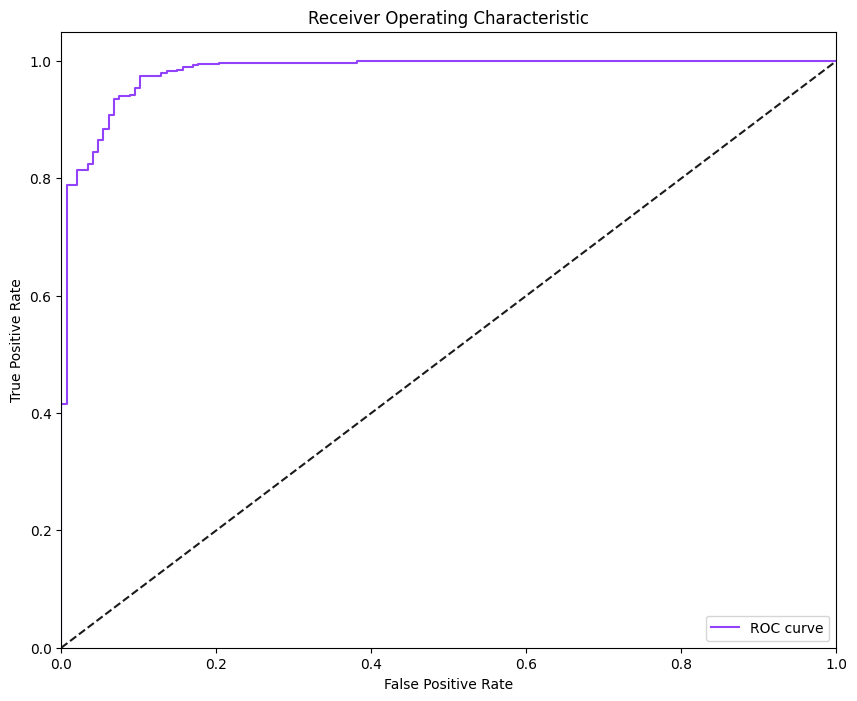

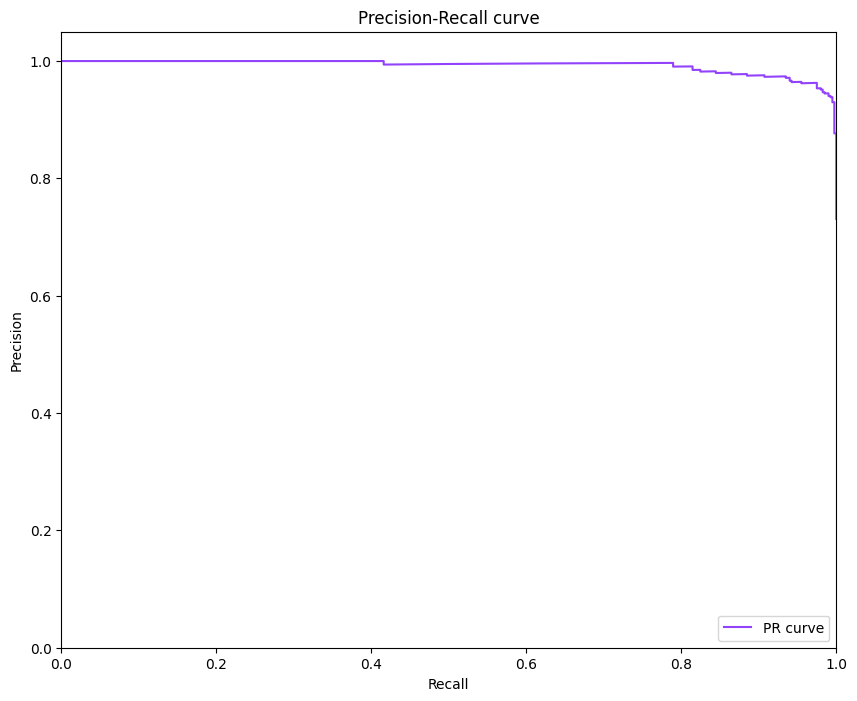

<ipython-input-12-82282e5212f2>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true_tensor = torch.tensor(y_true)


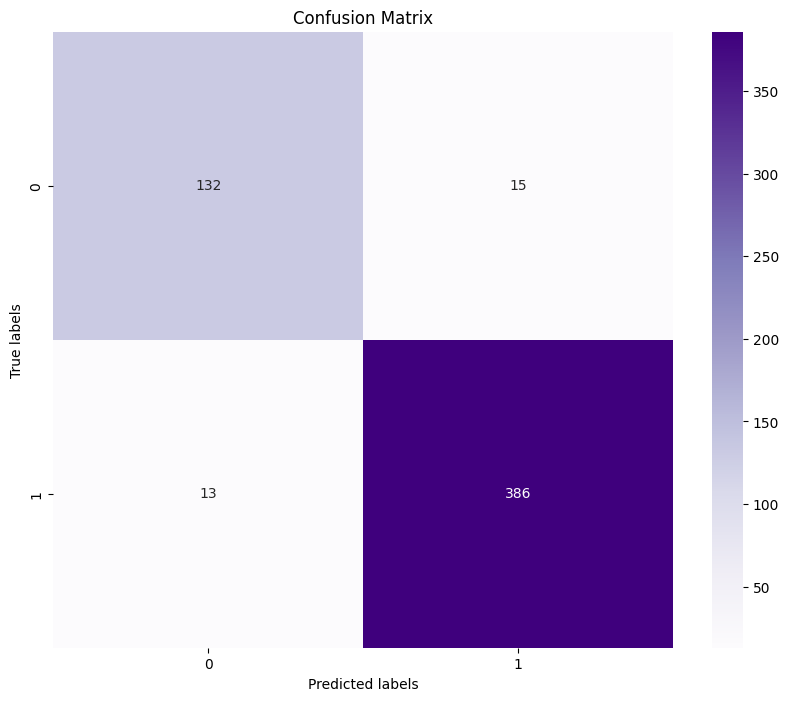

test  auc: 0.957  acc: 0.923  auprc: 0.947  recall: 0.910  f1_score: 0.904  precision: 0.898


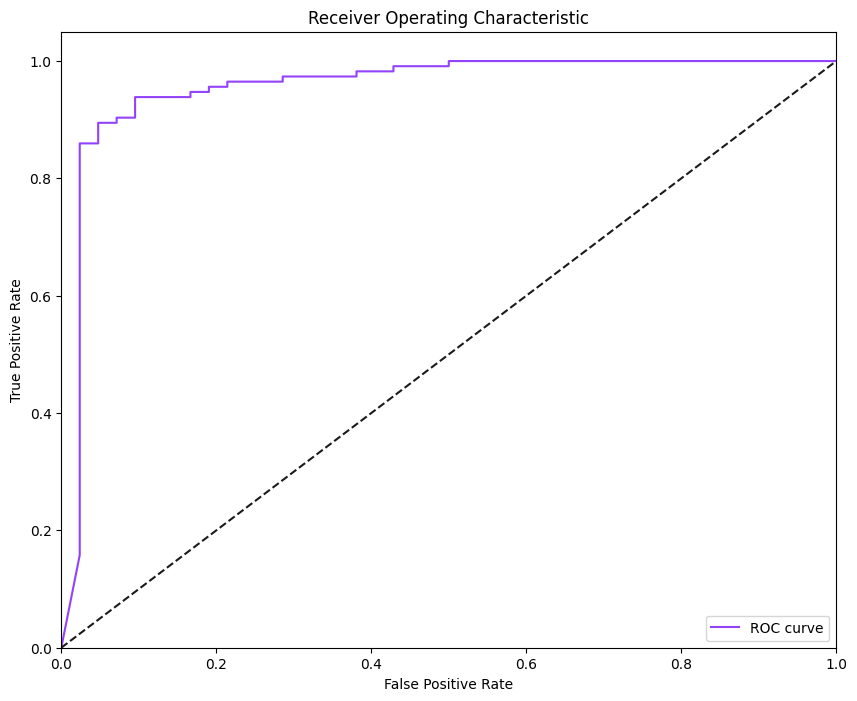

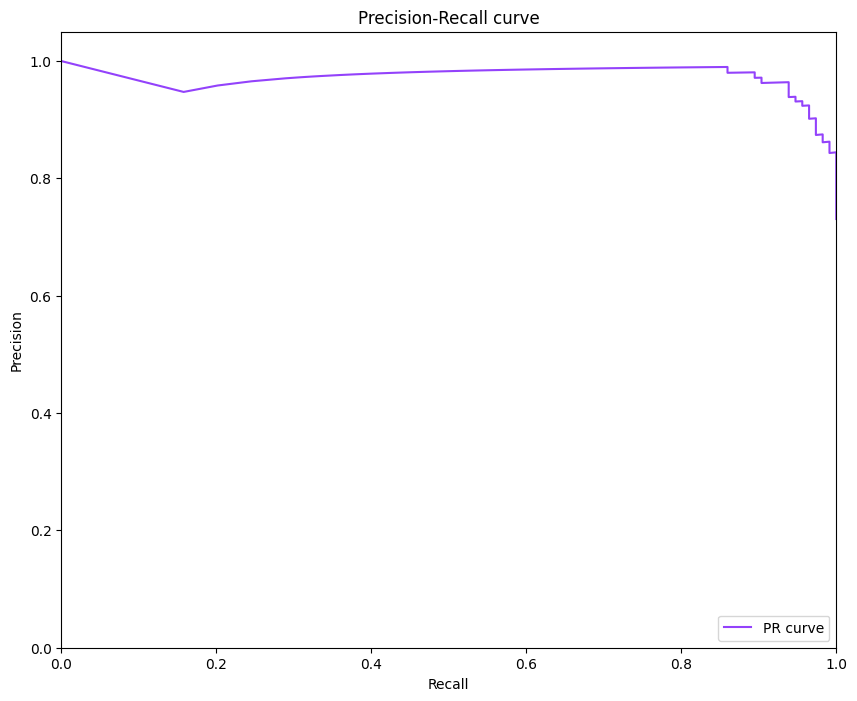

<ipython-input-12-82282e5212f2>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true_tensor = torch.tensor(y_true)


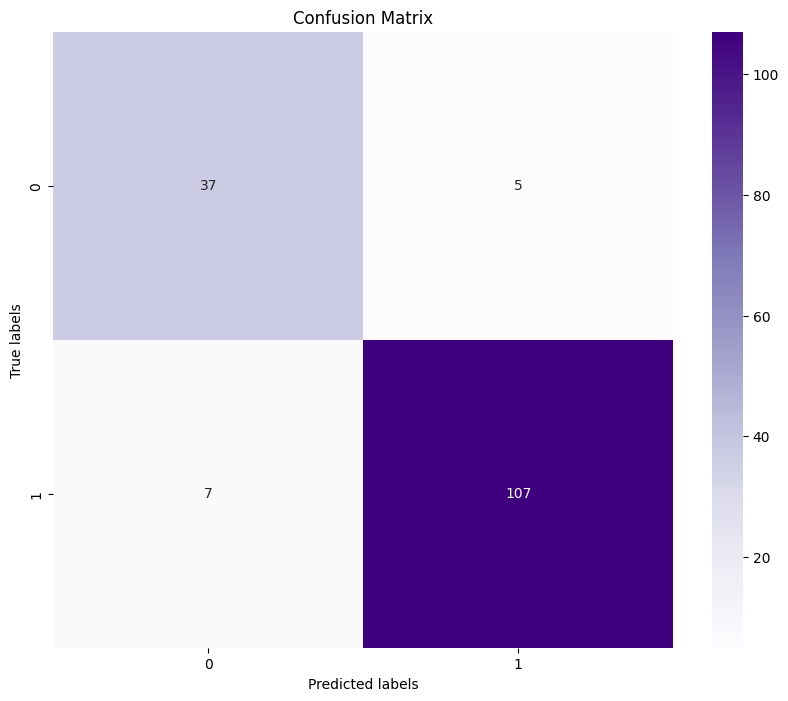

In [ ]:
def test(split):
    """
    A method to test the model.

    :param split: The split to test the model on.

    :return: The evaluation metrics.
    """

    # Set the model to evaluation mode
    model.eval()

    # Set the true and predicted labels to empty tensors
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)

    # Initialize lists to store the predicted labels, class probabilities, and true labels
    y_pred_list = []
    y_score_list = []
    y_true_list = []

    # Initialize the metrics (AUPRC, recall, and precision)
    auprc = MulticlassAUPRC(num_classes=n_classes)
    recall = Recall(average='macro')
    precision = Precision(average='macro')

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            # Move inputs and targets to the device
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().to(torch.int64)
                outputs = outputs.softmax(dim=-1)

            # Concatenate the true and predicted labels
            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

            # Get the predicted labels
            y_pred = torch.argmax(outputs, dim=1)
            y_pred_list.append(y_pred.cpu().numpy())

            # Get the class probabilities
            y_score_list.append(outputs.cpu().numpy())
            y_true_list.append(targets.cpu().numpy())

        y_true_ROC = y_true
        y_score_ROC = y_score

        # Convert the true and predicted labels to NumPy arrays
        y_true = y_true.cpu().numpy()
        y_score = y_score.cpu().detach().numpy()

        # Compute the evaluation metrics
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        # Compute the AUPRC, Recall, Precision, and F1 Score
        auprc.update(torch.tensor(y_score), torch.tensor(y_true.flatten()))
        auprc_value = auprc.compute()
        recall.update((torch.tensor(y_score), torch.tensor(y_true.flatten()).long()))
        avg_recall = recall.compute()
        precision.update((torch.tensor(y_score), torch.tensor(y_true.flatten()).long()))  # Flatten y_true
        avg_precision = precision.compute()
        y_true = torch.tensor(y_true).long()  # Convert y_true to int64
        f1_score = F1.multiclass_f1_score(torch.tensor(y_score), y_true, average='macro', num_classes=n_classes)

        # Print the evaluation metrics
        print('%s  auc: %.3f  acc: %.3f  auprc: %.3f  recall: %.3f  f1_score: %.3f  precision: %.3f' % (split, *metrics, auprc_value, avg_recall, f1_score, avg_precision))

        # Plot the ROC curve, precision-recall curve, and confusion matrix
        plot_roc_curve(y_true_ROC, y_score_ROC)
        plot_precision_recall_curve(y_true_ROC, y_score_ROC)
        plot_confusion_matrix(y_true, y_score)

print('==> Evaluating ...')
test('train')
test('test')

## 4. 5-Fold Cross-validation

### Moving on with values:

Results:
Average Val AUC: 0.890
Average Val Accuracy: 0.865

Average Test AUC: 0.883
Average Test Accuracy: 0.846

In [ ]:
# Redefining the datasets
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
validate_dataset = DataClass(split='val', transform=data_transform, download=download)

# Concatenate the datasets
merged_dataset = ConcatDataset([train_dataset, validate_dataset, test_dataset])

# Initialize the KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize lists to store the AUC and accuracy values
test_aucs = []
test_accs = []
val_aucs = []
val_accs = []

# Creating a list of all indices
all_indices = list(range(len(merged_dataset)))

# Perform 5-fold cross-validation per descriptor
for fold, (train_indices, test_indices) in enumerate(kf.split(all_indices)):
    # Split the training indices into indices performing 3 training folds and 1 validation fold, and 1 test fold
    train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=1)

    # Creating the datasets
    train_dataset = torch.utils.data.Subset(merged_dataset, train_indices)
    val_dataset = torch.utils.data.Subset(merged_dataset, val_indices)
    test_dataset = torch.utils.data.Subset(merged_dataset, test_indices)

    # Creating the data loaders for the aforementioned datasets
    train_loader_kf = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader_kf = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
    test_loader_kf = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

    # Instantiate the model as previously done
    model = ModifiedResNet18(num_classes=n_classes, in_channels=n_channels, dropout=0.8)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)
    scheduler = StepLR(optimizer, step_size=20, gamma=0.7)

    # Training as previously done
    patience = 7
    best_metric_sum = -float('inf')
    counter = 0

    for epoch in range(NUM_EPOCHS):
        model.train()
        for inputs, targets in tqdm(train_loader_kf):
            optimizer.zero_grad()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

        model.eval()
        val_loss = 0
        val_batches = 0
        with torch.no_grad():
            y_true = torch.tensor([]).to(device)
            y_score = torch.tensor([]).to(device)
            for inputs, targets in val_loader_kf:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                targets = targets.squeeze().long()
                loss = criterion(outputs, targets)
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)
                val_loss += loss.item()
                val_batches += 1
                y_true = torch.cat((y_true, targets), 0)
                y_score = torch.cat((y_score, outputs), 0)

            accuracy = accuracy_score(y_true.cpu().numpy(), y_score.cpu().numpy().argmax(axis=1))
            auc = roc_auc_score(y_true.cpu().numpy(), y_score.cpu().numpy()[:, 1])

            val_loss /= val_batches
            metric_sum = (auc + accuracy) / 2

            if metric_sum > best_metric_sum:
                best_metric_sum = metric_sum
                counter = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                counter += 1

            if counter >= patience:
                print("Early stopping: Stop training after {} epochs of no improvement in AUC and accuracy".format(
                    patience))
                break

    model.load_state_dict(torch.load('best_model.pth'))

    # Validating the model

    model.eval()
    with torch.no_grad():
        y_true = torch.tensor([]).to(device)
        y_score = torch.tensor([]).to(device)
        for inputs, targets in val_loader_kf:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            outputs = outputs.softmax(dim=-1)
            targets = targets.float().resize_(len(targets), 1)

            val_loss += loss.item()
            val_batches += 1
            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        accuracy = accuracy_score(y_true.cpu().numpy(), y_score.cpu().numpy().argmax(axis=1))
        auc = roc_auc_score(y_true.cpu().numpy(), y_score.cpu().numpy()[:, 1])

        val_aucs.append(auc)
        val_accs.append(accuracy)

        print('Validation Fold {}:  auc: {:.3f}  acc: {:.3f}'.format(fold + 1, auc, accuracy))

    # Testing the model

    model.eval()
    with torch.no_grad():
        y_true = torch.tensor([]).to(device)
        y_score = torch.tensor([]).to(device)
        for inputs, targets in test_loader_kf:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            outputs = outputs.softmax(dim=-1)
            targets = targets.float().resize_(len(targets), 1)
            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        accuracy = accuracy_score(y_true.cpu().numpy(), y_score.cpu().numpy().argmax(axis=1))
        auc = roc_auc_score(y_true.cpu().numpy(), y_score.cpu().numpy()[:, 1])

        test_aucs.append(auc)
        test_accs.append(accuracy)

        print('Test Fold {}:  auc: {:.3f}  acc: {:.3f}'.format(fold + 1, auc, accuracy))

# Calculate the average AUC and accuracy values
avg_val_auc = sum(val_aucs) / len(val_aucs)
avg_val_acc = sum(val_accs) / len(val_accs)
avg_test_auc = sum(test_aucs) / len(test_aucs)
avg_test_acc = sum(test_accs) / len(test_accs)

# Print the results
print('\nResults:')
print('Average Val AUC: {:.3f}'.format(avg_val_auc))
print('Average Val Accuracy: {:.3f}\n'.format(avg_val_acc))

print('Average Test AUC: {:.3f}'.format(avg_test_auc))
print('Average Test Accuracy: {:.3f}\n'.format(avg_test_acc))


Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 15/15 [00:00<00:00, 21.14it/s]


Early stopping: Stop training after 7 epochs of no improvement in AUC and accuracy
Validation Fold 1:  auc: 0.906  acc: 0.872
Test Fold 1:  auc: 0.885  acc: 0.859


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 15/15 [00:00<00:00, 52.67it/s]


Early stopping: Stop training after 7 epochs of no improvement in AUC and accuracy
Validation Fold 2:  auc: 0.930  acc: 0.865
Test Fold 2:  auc: 0.897  acc: 0.853


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 15/15 [00:00<00:00, 48.71it/s]


Early stopping: Stop training after 7 epochs of no improvement in AUC and accuracy
Validation Fold 3:  auc: 0.894  acc: 0.910
Test Fold 3:  auc: 0.892  acc: 0.840


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 15/15 [00:00<00:00, 34.63it/s]


Early stopping: Stop training after 7 epochs of no improvement in AUC and accuracy
Validation Fold 4:  auc: 0.826  acc: 0.814
Test Fold 4:  auc: 0.864  acc: 0.814


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 15/15 [00:00<00:00, 50.10it/s]


Validation Fold 5:  auc: 0.896  acc: 0.865
Test Fold 5:  auc: 0.878  acc: 0.865

Results:
Average Val AUC: 0.890
Average Val Accuracy: 0.865

Average Test AUC: 0.883
Average Test Accuracy: 0.846



## 1. Random Search for hyperparameters

###Mini-Batch Size: 32
###Learning Rate: 0.001
###Dropout = 0.8
###Momentum = 0.9
###Weight Decay = 0.0001
###Step Size = 20
###Gamma = 0.7

In [ ]:
# Defining the hyperparameter search space
hyperparameter_search_space = {
    'lr': [0.01, 0.001, 0.0001],
    'batch_size': [16, 32, 64],
    'step_size': [15, 20, 25],
    'gamma': [0.5, 0.6, 0.7, 0.8],
    'momentum': [0.9, 0.95, 0.99],
    'weight_decay': [0.001, 0.0001, 0.00001],
    'dropout': [0.6, 0.7, 0.8, 0.9]
}

def train_evaluate(lr, batch_size, step_size, gamma, momentum, weight_decay, dropout):
    """
    A method to train and evaluate the model with the provided hyperparameters.

    :param lr: The learning rate.
    :param batch_size: The mini-batch size.
    :param step_size: The step size for the learning rate scheduler.
    :param gamma: The gamma value for the learning rate scheduler.
    :param momentum: The momentum value for the optimizer.
    :param weight_decay: The weight decay value for the optimizer.
    :param dropout: The dropout rate.

    :return: The model and evaluation metrics.
    """

    # Create the model, criterion, optimizer, and learning rate scheduler with the provided hyperparameters
    model = ModifiedResNet18(num_classes=n_classes, in_channels=n_channels, dropout=dropout)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

    train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = data.DataLoader(dataset=validate_dataset, batch_size=2*batch_size, shuffle=False)

    patience = 7
    best_metric_sum = -float('inf')
    counter = 0

    for epoch in range(NUM_EPOCHS):
        model.train()
        for inputs, targets in tqdm(train_loader):
            optimizer.zero_grad()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                loss = criterion(outputs, targets)
            else:
                targets = targets.squeeze().long()
                loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()
        scheduler.step()

        model.eval()
        val_loss = 0
        val_batches = 0

        with torch.no_grad():
            y_true = torch.tensor([]).to(device)
            y_score = torch.tensor([]).to(device)

            for inputs, targets in validation_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)

                if task == 'multi-label, binary-class':
                    targets = targets.to(torch.float32)
                    loss = criterion(outputs, targets)
                    outputs = outputs.softmax(dim=-1)
                else:
                    targets = targets.squeeze().long()
                    loss = criterion(outputs, targets)
                    outputs = outputs.softmax(dim=-1)
                    targets = targets.float().resize_(len(targets), 1)

                val_loss += loss.item()
                val_batches += 1
                y_true = torch.cat((y_true, targets), 0)
                y_score = torch.cat((y_score, outputs), 0)

            evaluator = Evaluator(data_flag, 'val')
            metrics = evaluator.evaluate(y_score.cpu().numpy())

            auc = metrics[0]
            accuracy = metrics[1]

            print('Epoch %d: Validation auc: %.3f, acc: %.3f' % (epoch + 1, auc, accuracy))

            val_loss /= val_batches

            metric_sum = (auc + accuracy) / 2

            if metric_sum > best_metric_sum:
                best_metric_sum = metric_sum
                counter = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                counter += 1

            if counter >= patience:
                print("Early stopping: Stop training after {} epochs of no improvement in AUC and accuracy".format(patience))
                break

    model.load_state_dict(torch.load('best_model.pth'))

    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)

    data_loader = validation_loader
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)
        y_true = y_true.cpu().numpy()
        y_score = y_score.cpu().detach().numpy()
        evaluator = Evaluator(data_flag, 'val')
        metrics = evaluator.evaluate(y_score)

        print('val  auc: %.3f  acc:%.3f' % (*metrics,))
    return model, metrics



def random_search():
    """
    A method to perform random search for hyperparameter optimization.

    :return: The best hyperparameters.
    """

    # Initialize the best AUC, accuracy, and hyperparameters
    best_auc = 0
    best_acc = 0
    best_hyperparameters = None

    # Perform 100 trials
    for trial in range(100):

      print("Trial: " + str(trial))

      # Use random search to sample hyperparameters
      lr = random.choice(hyperparameter_search_space['lr'])
      batch_size = random.choice(hyperparameter_search_space['batch_size'])
      step_size = random.choice(hyperparameter_search_space['step_size'])
      gamma = random.choice(hyperparameter_search_space['gamma'])
      momentum = random.choice(hyperparameter_search_space['momentum'])
      weight_decay = random.choice(hyperparameter_search_space['weight_decay'])
      dropout = random.choice(hyperparameter_search_space['dropout'])

      # Conduct training and evaluation with the sampled hyperparameters
      model, (auc, acc) = train_evaluate(lr, batch_size, step_size, gamma, momentum, weight_decay, dropout)

      # Check if the AUC and accuracy are better than the previous best values
      if auc >= best_auc and acc >= best_acc:

        # Update the best AUC, accuracy, and hyperparameters
        best_auc = auc
        best_acc = acc
        best_hyperparameters = {'lr': lr, 'batch_size': batch_size, 'step_size': step_size, 'gamma': gamma, 'momentum': momentum, 'weight_decay': weight_decay, 'dropout': dropout}

        # Print the best hyperparameters
        print('New Best Hyperparameters:', best_hyperparameters)

    return best_hyperparameters


# Conduct the random search
run = False

if run == True:
    best_hyperparameters = random_search()
    print('Best hyperparameters:', best_hyperparameters)



